Assignment 3
Hana McMahon-Cole 

First, I converted the data into a usable format,  selecting for date, time and air temperature and converting this into an ordinal format. Finally, I removed null values from the data set so this would not factor into model performance. 

Then I covered  each input dimension with a list of radial basis functions, mapping (d,t) into (Φ₁(d), Φ₂(t)). 
In order to generate the rbf kernels, I needed to set the gamma parameter. From sklearn"This parameter basically defines how far the influence of a single training example reaches, low meaning far and high meaning close." Given this, I decided to set an intermediate gamma value in order to avoid overfiting the data. Rather than setting a very large sigma (which would result in a small gamma) I set sigma based on the center outputs (center[3]-center[0]), to output a smaller sigma, outputting an intermediate gamma value. This was in an attempt to capture the most salient features of the data, but not try to too closely fit the data. 

Then I input the rbf_kernels to the RIDGE linear regression model in order to "solve" the regression model. The output two slopes and one coefficient which could be used to predict a given y value. Then I plotted the training data against the daily, yearly and full model predictions. Then I plotted the test data against the daily, yearly and full model predictions. 

My model had the following R2 scores: full model: 0.5699945251908944, yearly: 0.06840966642898172 and daily:-0.3555324193679845. These are reasonable R2 scores, as overall the model performs fairly well, the closer the R2 score is to 1 the better it is. Moreover the year R2 scores are reasonable as we would expect the year to get a bit warmer later, while the day gets a lot colder later, hence the negative score. The R2 score for the testing model was shockingly similar: R2 for full model:0.5715169491669105, R2 for daily model:-0.34524877720918146 and R2 for yearly model:0.07521552302180412. This could indicate that something was done incorrectly, as we would expect the test data to perform more poorly than the training. It could also indicate that my precautions in trying not to overfit the model worked - and the most salient aspects on the training data were captured in both the training and testing data. 

The overall model score could likely be improved by adding more radial basis functions, in order to more closely fit the data. Because of this, it is tempting to use a lot of radial basis functions to better represent the data. However, using too many radial basis functions also presents the potential for overfitting, more closely fitting to all features of the training data, such that the model has low predictive power in novel datasets such as the test data set. Similarly, model performance could likely be improved by lowering the sigma value yet would likely also decrease performance on the testing data.

Note: Some pieces of assignment code were taken from PCW 3.1 links. 

In [205]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn import metrics
from datetime import datetime

#1 Importing & cleaning data

In [206]:
headers = ('WBAN_number', 'Date1', 'Time1', 'Date2', 'Time2', 'CRX_version',
        'longitude', 'latitude', 'Air_Temp', 'Precepitation', 'Solar_rad',
        'SR_flag', 'surface_temperature', 'ST_type', 'ST_flag', 'relative_humidity', 'RH_flag',
        'soil_moisture', 'soil_temperature', 'wetness', 'wet_flag', 'wind', 'wind_flag')

#data
years = range(2011, 2016)
path = 'Yosemite/{year}.txt'
all_data = pd.concat(
    [pd.read_table(path.format(year=year), sep=r'\s+', header=None, names=headers, converters={'Date1': lambda x: str(x)})
                                       for year in years])
#suggested by gili
print(all_data.shape)
all_data.head()

(525888, 23)


,WBAN_number,Date1,Time1,Date2,Time2,CRX_version,longitude,latitude,Air_Temp,Precepitation,...,ST_type,ST_flag,relative_humidity,RH_flag,soil_moisture,soil_temperature,wetness,wet_flag,wind,wind_flag
0,53150,20110101,5,20101231,1605,2,-119.82,37.76,-6.4,0.0,...,U,0,-9999,0,-99.0,-9999.0,1218,0,-99.0,0
1,53150,20110101,10,20101231,1610,2,-119.82,37.76,-6.5,0.0,...,U,0,-9999,0,-99.0,-9999.0,1223,0,-99.0,0
2,53150,20110101,15,20101231,1615,2,-119.82,37.76,-6.5,0.0,...,U,0,-9999,0,-99.0,-9999.0,1223,0,-99.0,0
3,53150,20110101,20,20101231,1620,2,-119.82,37.76,-6.5,0.0,...,U,0,-9999,0,-99.0,-9999.0,1224,0,-99.0,0
4,53150,20110101,25,20101231,1625,2,-119.82,37.76,-6.7,0.0,...,U,0,-9999,0,-99.0,-9999.0,1210,0,-99.0,0


In [207]:
key_features = ['Date1','Time1', 'Air_Temp']

all_data = all_data.loc[:,key_features]
all_data.head()

,Date1,Time1,Air_Temp
0,20110101,5,-6.4
1,20110101,10,-6.5
2,20110101,15,-6.5
3,20110101,20,-6.5
4,20110101,25,-6.7


In [208]:
#convert times to ordinal 
to_ord_min = lambda x: np.floor_divide(x, 100) * 60 + np.mod(x, 100)
to_ord_day = lambda x: datetime.strptime(str(x), '%Y%m%d').timetuple().tm_yday
 
all_data.Time1 = all_data.Time1.astype('int').apply(to_ord_min)
all_data.Date1 = all_data.Date1.apply(to_ord_day)
# remove null values  
all_data = all_data.replace({-9999.0: None}).dropna()
all_data.head()

,Date1,Time1,Air_Temp
0,1,5,-6.4
1,1,10,-6.5
2,1,15,-6.5
3,1,20,-6.5
4,1,25,-6.7


#2 Apply RBF(s)
Cover each input dimension with a list of radial basis functions. This turns the pair of inputs into a much richer representation, mapping (d,t) into (Φ₁(d), Φ₂(t)). Experiment with different numbers of radial basis functions and different widths of the radial basis function in different dimensions.

In [209]:
X_d = np.array(all_data.Date1)
X_d = X_d.reshape(-1, 1)
X_m = np.array(all_data.Time1)
X_m = X_m.reshape(-1, 1)

#combine x's
X = np.concatenate((X_m, X_d), axis = 1)
(x_train, x_test, y_train, y_test) = train_test_split(X , all_data.Air_Temp, test_size=0.2) #split test train data

center_num = 100 
centers = np.linspace(min (all_data.Time1), max(all_data.Time1) ,int(center_num)).reshape(-1,1) 


sigma = np.abs(centers[3] - centers[0])
alpha = 0.0001 #learning step

print('sigma:', sigma)

# New representation:
x_m_train = rbf_kernel(x_train[:,0].reshape(-1, 1), centers, gamma=1 / sigma)
x_d_train = rbf_kernel(x_train[:,1].reshape(-1, 1), centers, gamma=1 / sigma)

x_m_test = rbf_kernel(x_test[:,0].reshape(-1, 1), centers, gamma=1 / sigma)
x_d_test = rbf_kernel(x_test[:,1].reshape(-1, 1), centers, gamma=1 / sigma)


x_all_train = np.concatenate((x_m_train,x_d_train),axis=1)
regr_rbf = Ridge(alpha=alpha, fit_intercept=False)
regr_rbf.fit(x_all_train, y_train)
tr_pred_all = regr_rbf.predict(x_all_train)

print("Score on training data = ", regr_rbf.score(x_all_train, y_train))

#test
x_all_test = np.concatenate((x_m_test,x_d_test),axis=1)
ts_pred_all = regr_rbf.predict(x_all_test)


print(len(x_all_test))
print(len(x_all_train))

sigma: [43.48484848]
Score on training data =  0.570113950788412
105096
420384


Using this new representation, build a linear parameter model that captures both seasonal variations and daily variations.

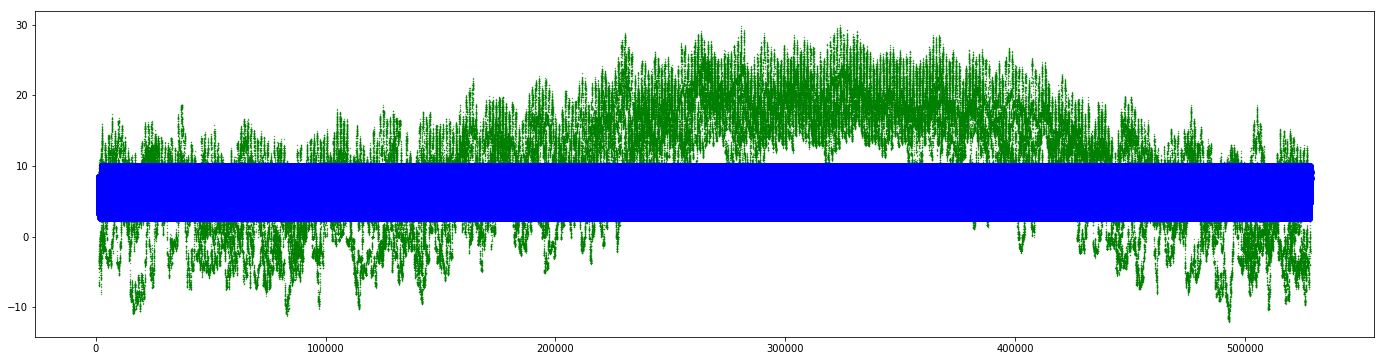

In [210]:
#plot y_predictions from daily feature
fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)

#y_predictions from rbf for minutes 
y_m_tr = np.sum(x_all_train[:,:center_num]*regr_rbf.coef_[:center_num],axis=1)+regr_rbf.intercept_
#y_m_ts = np.sum(x_all_test[:,:center_num]*regr_rbf.coef_[:center_num],axis=1)+regr_rbf.intercept_

train_time = (x_train[:,1]*1440)+x_train[:,0] #convert to minutes 
ax.scatter(train_time, y_train,s=0.1,color='green') #plot all the training data  
plt.scatter(train_time, y_m_tr, color='blue') #plots y predictions 
plt.show()


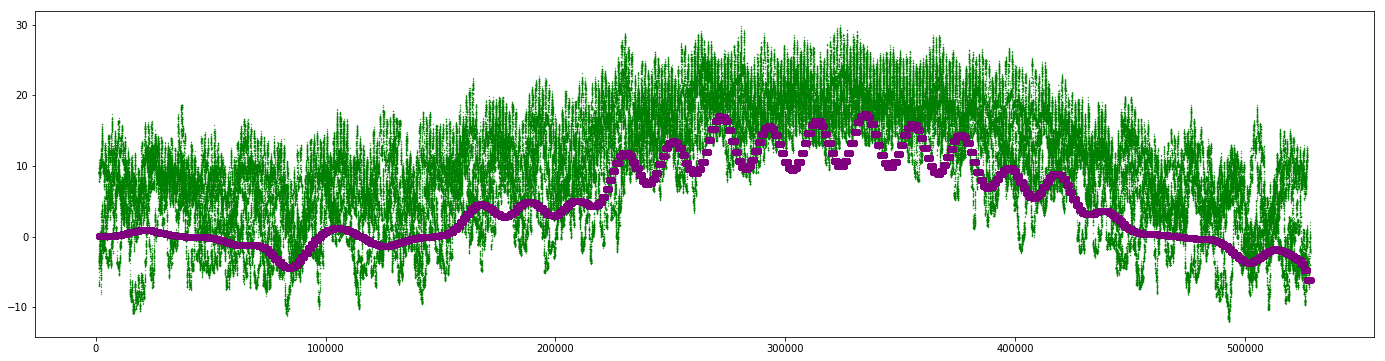

In [211]:
#plot y_predictions from yearly feature 

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)

#y_predictions from rbf for days 
y_d_tr = np.sum(x_all_train[:,center_num:]*regr_rbf.coef_[center_num:],axis=1)+regr_rbf.intercept_

train_time = (x_train[:,1]*1440)+x_train[:,0] #convert to minutes 
ax.scatter(train_time, y_train,s=0.1,color='green') #plot all the training data  
plt.scatter(train_time, y_d_tr, color='purple') #plots y predictions 
plt.show()


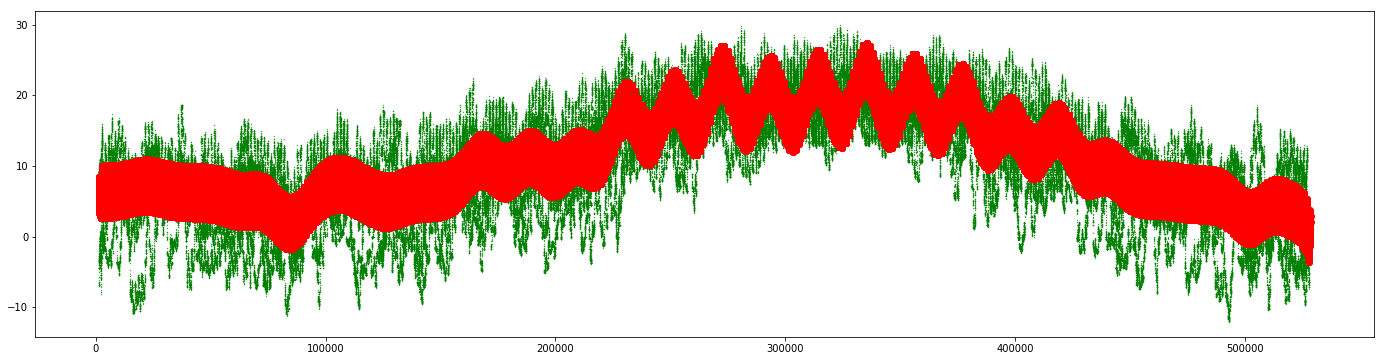

In [212]:
#y_predictions from full model
fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
#all_data = all_data.Air_Temp
train_time = (x_train[:,1]*1440)+x_train[:,0] #convert to minutes 
ax.scatter(train_time, y_train,s=0.1,color='green') #plot all the training data  
plt.scatter(train_time, tr_pred_all, color='red')
tr_pred_all
plt.show()

#Applying to test data 

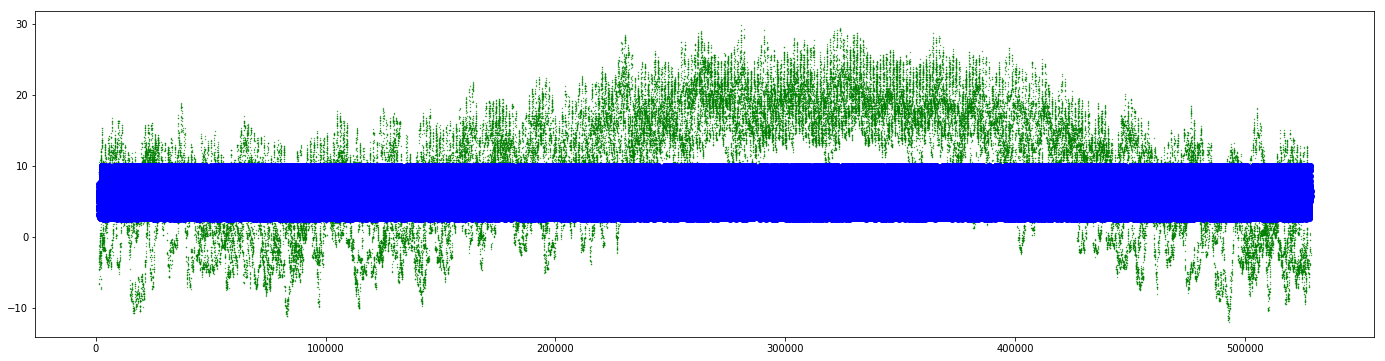

In [214]:
#All y_predictions using daily features
fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)

y_m_ts = np.sum(x_all_test[:,:center_num]*regr_rbf.coef_[:center_num],axis=1)+regr_rbf.intercept_
test_time = (x_test[:,1]*1440)+x_test[:,0] #convert to minutes 
ax.scatter(test_time, y_test,s=0.1,color='green') #plot all the training data  
plt.scatter(test_time, y_m_ts, color='blue')
plt.show()

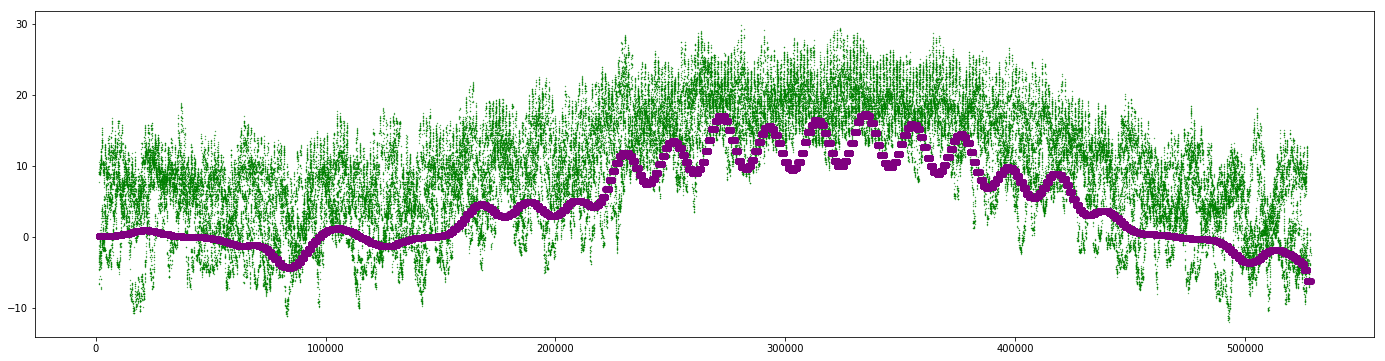

In [215]:
#All y_predictions using yearly features
fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)

y_d_ts = np.sum(x_all_test[:,center_num:]*regr_rbf.coef_[center_num:],axis=1)+regr_rbf.intercept_

#all_data = all_data.Air_Temp
test_time = (x_test[:,1]*1440)+x_test[:,0] #convert to minutes 
ax.scatter(test_time, y_test,s=0.1,color='green') #plot all the training data  
plt.scatter(test_time, y_d_ts, color='purple')
plt.show()

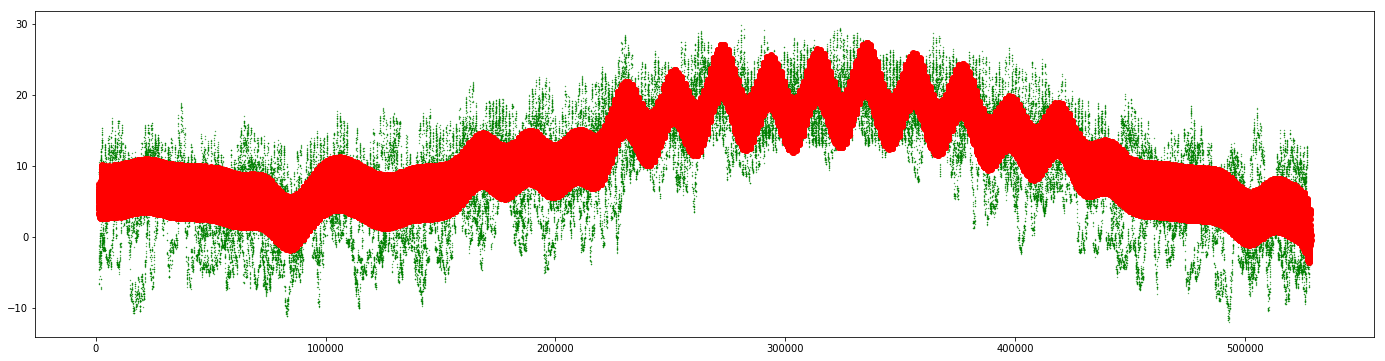

In [216]:
#All y_predictions using full model features 
fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
#all_data = all_data.Air_Temp
test_time = (x_test[:,1]*1440)+x_test[:,0] #convert to seconds 
ax.scatter(test_time, y_test,s=0.1,color='green') #plot all the training data  
plt.scatter(test_time, ts_pred_all, color='red')
plt.show()

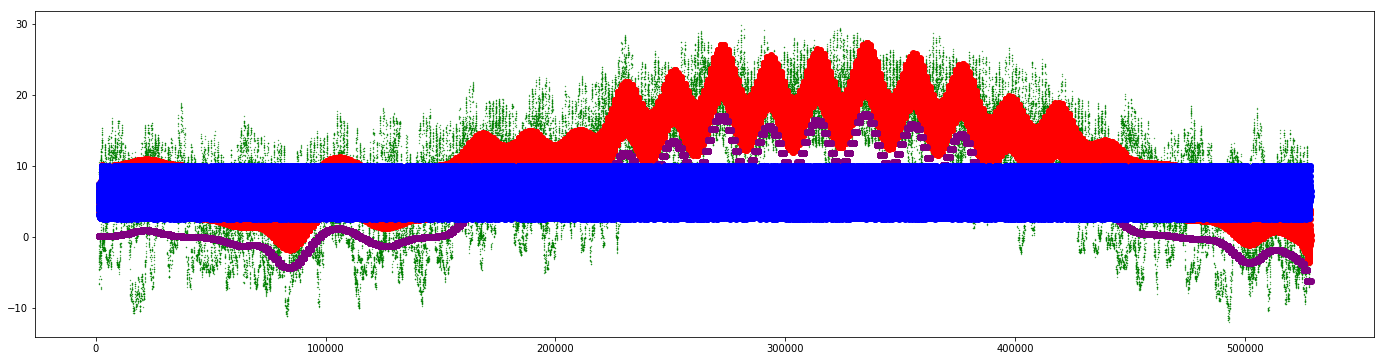

In [217]:
#All y_predictions using all features to predict
fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
#all_data = all_data.Air_Temp
test_time = (x_test[:,1]*1440)+x_test[:,0] #convert to seconds 
ax.scatter(test_time, y_test,s=0.1,color='green') #plot all the training data  
plt.scatter(test_time, ts_pred_all, color='red')
plt.scatter(test_time, y_d_ts, color='purple')
plt.scatter(test_time, y_m_ts, color='blue')
plt.show()

#5.Quantify Performance

In [218]:
#Quantify model performance using all of the data
print('Training Model:')
print(f'R2 for full model:{metrics.r2_score(y_train, tr_pred_all)}')
print(f'R2 for daily model:{metrics.r2_score(y_train, y_m_tr)}')
print(f'R2 for yearly model:{metrics.r2_score(y_train, y_d_tr)}')

print('Testing Model:')
print(f'R2 for full model:{metrics.r2_score(y_test, ts_pred_all)}')
print(f'R2 for daily model:{metrics.r2_score(y_test, y_m_ts)}')
print(f'R2 for yearly model:{metrics.r2_score(y_test, y_d_ts)}')

print('Testing Model:')
tr_pred_all = regr_rbf.predict(x_all_train)
print('MAE:', metrics.mean_absolute_error(y_train, tr_pred_all))
print('RMSE is:', np.sqrt(metrics.mean_squared_error(y_train, tr_pred_all)))
print('Training Model:')
ts_pred_all = regr_rbf.predict(x_all_test)
print('MAE:', metrics.mean_absolute_error(y_test, ts_pred_all))
print('RMSE is:', np.sqrt(metrics.mean_squared_error(y_test, ts_pred_all)))

Training Model:
R2 for full model:0.570113950788412
R2 for daily model:-0.35662601365649693
R2 for yearly model:0.06640035670485245
Testing Model:
R2 for full model:0.5715169491669105
R2 for daily model:-0.34524877720918146
R2 for yearly model:0.07521552302180412
Testing Model:
MAE: 4.171213373772127
RMSE is: 5.128422847669165
Training Model:
MAE: 4.1767820096666055
RMSE is: 5.1362732015403605
